In [1]:
###### cell 0
#cell for imports and system variable set ups
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
from tqdm import tqdm
import sys
#sys.path.append('.'+os.sep+"src")
import tensorflow as tf
from tensorflow import keras
#import keras
from tensorflow.python.client import device_lib
#from tensorflow.keras import backend
from tensorflow.python.framework import ops
#import random
import numpy as np
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt
import cmath
from sklearn import metrics
from src.complex_net.nn.layers.dense import ComplexDense
from src.complex_net.nn.layers.activations import ComplexReLU as cReLU

from src.complex_net.nn.models.fc import *

from src.complex_net.nn.models.biofc import *

from src.complex_net.nn.models.cnn import *

from src.complex_net.nn.optimizers.cadam import *

from src.complex_net.data.musicnet import *

from src.complex_net.nn.initializers.complex_glorot_uniform import ComplexGlorotUniform

from src.real_net.nn.models.fc_real import *

from src.real_net.data.musicnet_real import *

from dataset import *

import random
print("Done")

Using TensorFlow backend.


Done


In [ ]:
dset= tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = dset.load_data()

all_images = np.concatenate((train_images,test_images),0)
all_labels = np.concatenate((train_labels,test_labels),0)


In [11]:
dset= tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = dset.load_data()

all_images = np.concatenate((train_images,test_images),0)
all_labels = np.concatenate((train_labels,test_labels),0)

all_images = np.squeeze(np.asarray((tf.image.rgb_to_grayscale(all_images))))

In [12]:
print(all_images.shape)
print(all_labels.shape)

(60000, 32, 32)
(60000, 1)


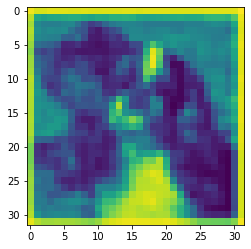

In [16]:
plt.imshow(all_images[500])

In [ ]:
X_test = test_images
y_test = test_labels
X_test = X_test.reshape(1,X_test.shape[0],X_test.shape[1]*X_test.shape[2])
X_test = (X_test/256.0).astype('float32')
y_temp = np.zeros((y_test.size, int(y_test.max())+1))
y_temp[np.arange(y_test.size),y_test] = 1
y_test = y_temp.reshape(1, y_temp.shape[0], y_temp.shape[1])
print("x_test: ", X_test.shape)
print(y_test.shape)


In [ ]:
dset = np.load("./low_dim_scales/low_dim_scale_1.npz")
dset = dset['x']
labels = np.load("./low_dim_scales/low_dim_labels.npz")
labels = labels['labels']

In [ ]:
print(dset.shape)

In [ ]:
#537482
split = 10062
shuffler = np.random.permutation(len(dset))
dset = dset[shuffler]
labels = np.reshape(labels[shuffler],(labels[shuffler].size,))
train_images = dset[:-split]
test_images = dset[-split:]
train_labels = labels[:-split]
test_labels = labels[-split:]

X_train = train_images
y_train = train_labels
#shuffler = np.random.permutation(len(X_train))
#X_train = X_train[shuffler]
#y_train = y_train[shuffler]
batches = train_images.shape[0]//50
if X_train.ndim == 3:
    X_train = X_train.reshape(batches,X_train.shape[0]//batches,X_train.shape[1]*X_train.shape[2])
elif X_train.ndim == 2:
    X_train = X_train.reshape(batches,X_train.shape[0]//batches,X_train.shape[1])
X_train = (X_train/256.0).astype('float32')
y_temp = np.zeros((y_train.size, int(y_train.max())+1))
y_temp[np.arange(y_train.size),y_train] = 1
y_train = y_temp.reshape(batches,y_temp.shape[0]//batches,y_temp.shape[1])
print("x_train: ", X_train.shape)
print(y_train.shape)
        
X_test = test_images
y_test = test_labels
X_test = X_test.reshape(1,X_test.shape[0],X_test.shape[1])
X_test = (X_test/256.0).astype('float32')
y_temp = np.zeros((y_test.size, int(y_test.max())+1))
y_temp[np.arange(y_test.size),y_test] = 1
y_test = y_temp.reshape(1, y_temp.shape[0], y_temp.shape[1])
print("x_test: ", X_test.shape)
print(y_test.shape)

In [ ]:
#penalize difference in phase
class customDense(tf.keras.layers.Layer):
    def __init__(self, num_units: int, **kwargs) -> None:
        super(customDense, self).__init__(**kwargs)
        self.num_units: int = int(num_units)

        self.W: tf.Variable = None
        self.b: tf.Variable = None
        self.p: tf.Variable = None

    # lazy parameter allocation...only allocate upon the first call to self.call(...)
    def build(self, input_shape: List[int]) -> None:
        #print("aisjd: ", input_shape)
        #print("asidj: ", self.num_units)
        W_init: GlorotUniform = ComplexGlorotUniform(input_shape[-1])
        b_init: GlorotUniform = tf.keras.initializers.GlorotUniform()

        self.W = self.add_weight(name='w',
                                 shape=(input_shape[-1], self.num_units,),
                                 initializer=W_init,
                                 dtype=tf.complex64,
                                 trainable=True)
        self.b = self.add_weight(name='b',
                                 shape=(1,self.num_units,),
                                 initializer=b_init,
                                 dtype=tf.float32,
                                 trainable=True)
        

    def P2C(self,radii, angles):
        x = tf.multiply(radii, tf.math.cos(angles))
        y = tf.multiply(radii, tf.math.sin(angles))
        return tf.cast(tf.complex(x,y),dtype='complex64')

    def call(self, X: tf.Tensor, **kwargs) -> tf.Tensor:
        #print("X: ", X)
        #print("w: ", self.W)
        out = 0.5*tf.matmul(X, tf.math.abs(self.W)) + 0.5*tf.math.abs(tf.matmul(tf.cast(tf.complex(X, tf.zeros(X.shape)),dtype='complex64'),self.W))
        return out + self.b

    def get_config(self) -> Dict:
        config: Dict[str, ...] = super(ComplexDense, self).get_config()
        config.update({"num_units": self.num_units})
        return config


In [ ]:
#penalize diff in phase and reward same phase:

class customDense2(tf.keras.layers.Layer):
    def __init__(self, num_units: int, activity_regularizer=None,**kwargs) -> None:
        super(customDense2, self).__init__(activity_regularizer=activity_regularizer, **kwargs)
        self.num_units: int = int(num_units)

        self.W: tf.Variable = None
        self.b: tf.Variable = None
        self.p: tf.Variable = None

    # lazy parameter allocation...only allocate upon the first call to self.call(...)
    def build(self, input_shape: List[int]) -> None:
        #print("aisjd: ", input_shape)
        #print("asidj: ", self.num_units)
        W_init: GlorotUniform = ComplexGlorotUniform(input_shape[-1])
        b_init: GlorotUniform = tf.keras.initializers.GlorotUniform()

        self.W = self.add_weight(name='w',
                                 shape=(input_shape[-1], self.num_units,),
                                 initializer=W_init,
                                 dtype=tf.complex64,
                                 trainable=True)
        self.b = self.add_weight(name='b',
                                 shape=(1,self.num_units,),
                                 initializer=b_init,
                                 dtype=tf.float32,
                                 trainable=True)
        

    def P2C(self,radii, angles):
        x = tf.multiply(radii, tf.math.cos(angles))
        y = tf.multiply(radii, tf.math.sin(angles))
        return tf.cast(tf.complex(x,y),dtype='complex64')

    def call(self, X: tf.Tensor, **kwargs) -> tf.Tensor:
        #print("X: ", X)
        #print("w: ", self.W)
        term_1 = tf.matmul(X, tf.math.abs(self.W))
        term_2 = tf.math.abs(tf.matmul(tf.cast(tf.complex(X, tf.zeros(X.shape)),dtype='complex64'),self.W))
        term_3 = (1-((term_1-term_2)/term_1))*term_1
        out = 0.5*term_1 + 0.5*term_2 + 0.5*term_3
        return out + self.b

    def get_config(self) -> Dict:
        config: Dict[str, ...] = super(ComplexDense, self).get_config()
        config.update({"num_units": self.num_units})
        return config


In [ ]:
class RealFC(tf.keras.Model):
    def __init__(self, decoder_dims: List[int], **kwargs) -> None:
        super(RealFC, self).__init__(**kwargs)
        self.decoder_dims: List[int] = list(decoder_dims)
        self.num_layers = len(self.decoder_dims)
        if len(self.decoder_dims) == 0:
            raise ValueError("ERROR: real_decoder_dims must have at least 1 element")

        self.decoder_layers = list()

        for num_units in self.decoder_dims[:-1]:
            if len(self.decoder_dims) == 1:
                self.decoder_layers.append(customDense2(num_units,activity_regularizer=tf.keras.regularizers.L2(0.01)))
                self.decoder_layers.append(tf.keras.layers.Activation('sigmoid'))
                #print('used sigmoid')
            else:
                self.decoder_layers.append(customDense2(num_units,activity_regularizer=tf.keras.regularizers.L2(0.)))
                self.decoder_layers.append(tf.keras.layers.ReLU(threshold=0.))
                self.decoder_layers.append(tf.keras.layers.BatchNormalization())
                #print("used relu")
        self.decoder_layers.append(customDense2(self.decoder_dims[-1]))
        self.decoder_layers.append(tf.keras.layers.Softmax())

    def call(self, X: tf.Tensor) -> tf.Tensor:
        #print(X)
        for layer in self.decoder_layers:
            #print(X)
            #print(layer)
            X = layer(X)
        return X

In [ ]:
class ComplexConvNet(tf.keras.Model):
    def __init__(self, conv_dims, decoder_dims, **kwargs) -> None:
        '''
        input:
            conv_dims: list[tuples], where each tuple = (num_filter, filter_shape, stride, padding)
                num_filter: int
                filter_shape: int
                stride: tuple
                padding = str, see TF documentation on Conv2D
            
        '''
        super(ConvNet, self).__init__(**kwargs)
        self.decoder_dims: List[int] = list(decoder_dims)
        self.conv_dims: List[int] = list(conv_dims)
        self.num_layers = len(self.decoder_dims)
        
        if len(self.decoder_dims) == 0:
            raise ValueError("ERROR: real_decoder_dims must have at least 1 element")

        self.decoder_layers = list()
        self.conv_layers = list()
        
        for i in range(len(self.conv_dims)):
            self.conv_layers.append(tf.keras.layers.Conv2D(conv_dims[i][0], conv_dims[i][1], strides=conv_dims[i][2], 
                                                           padding=conv_dims[i][3], activation='relu',trainable=True))
            self.conv_layers.append(tf.keras.layers.MaxPooling2D((2, 2)))
            
        for num_units in self.decoder_dims[:-1]:
            if len(self.decoder_dims) == 1:
                self.decoder_layers.append(customDense(num_units,activity_regularizer=tf.keras.regularizers.L2(0.01)))
                self.decoder_layers.append(tf.keras.layers.Activation('sigmoid'))
                #print('used sigmoid')
            else:
                self.decoder_layers.append(customDense(num_units,activity_regularizer=tf.keras.regularizers.L2(0.)))
                self.decoder_layers.append(tf.keras.layers.ReLU(threshold=0.))
                self.decoder_layers.append(tf.keras.layers.BatchNormalization())
                #print("used relu")
        self.decoder_layers.append(customDense2(self.decoder_dims[-1]))
        self.decoder_layers.append(tf.keras.layers.Softmax())
        
        print("conv layers: ", len(self.conv_layers), " || decoder layers: ", len(self.decoder_layers))
        
        print(self.conv_layers)
        print(self.decoder_layers)

    def call(self, X: tf.Tensor) -> tf.Tensor:
        #ACCIDENTALLY REMOVED FLATTEN LINE. POTENTIALLY DON'T NEED TO RE-ADD
        for layer in self.conv_layers:
            X = layer(X)
        for layer in self.decoder_layers:
            X = layer(X)
        return X

In [ ]:
class ConvNet(tf.keras.Model):
    def __init__(self, conv_dims, decoder_dims, **kwargs) -> None:
        '''
        input:
            conv_dims: list[tuples], where each tuple = (num_filter, filter_shape, stride, padding)
                num_filter: int
                filter_shape: int
                stride: tuple
                padding = str, see TF documentation on Conv2D
            
        '''
        super(ConvNet, self).__init__(**kwargs)
        self.decoder_dims: List[int] = list(decoder_dims)
        self.conv_dims: List[int] = list(conv_dims)
        self.num_layers = len(self.decoder_dims)
        
        if len(self.decoder_dims) == 0:
            raise ValueError("ERROR: real_decoder_dims must have at least 1 element")

        self.decoder_layers = list()
        self.conv_layers = list()
        
        for i in range(len(self.conv_dims)):
            self.conv_layers.append(tf.keras.layers.Conv2D(conv_dims[i][0], conv_dims[i][1], strides=conv_dims[i][2], 
                                                           padding=conv_dims[i][3], activation='relu',trainable=True))
            self.conv_layers.append(tf.keras.layers.MaxPooling2D((2, 2)))
        
        self.conv_layers.append(tf.keras.layers.Flatten())
        for num_units in self.decoder_dims[:-1]:
            self.decoder_layers.append(tf.keras.layers.Dense(num_units,activity_regularizer=tf.keras.regularizers.L2(0.)))
            self.decoder_layers.append(tf.keras.layers.ReLU(threshold=0.))
            self.decoder_layers.append(tf.keras.layers.BatchNormalization())

        self.decoder_layers.append(tf.keras.layers.Dense(self.decoder_dims[-1],activity_regularizer=tf.keras.regularizers.L2(0.)))
        self.decoder_layers.append(tf.keras.layers.Softmax())
        
        print("conv layers: ", len(self.conv_layers), " || decoder layers: ", len(self.decoder_layers))
        
        print("conv layers: ", self.conv_layers)
        print("")
        print("dense layers: ", self.decoder_layers)

    def call(self, X: tf.Tensor) -> tf.Tensor:
        for layer in self.conv_layers:
            X = layer(X)
        for layer in self.decoder_layers:
            X = layer(X)
        return X

In [ ]:
conv_dims = [(32,(3,3),1,'valid'),(64,(3,3),1,'valid'),(64,(3,3),1,'valid')]
dims = [20,10]
dims_str = "20,10_mnist_dense2"

In [ ]:
#%%capture output
#adjustable parameters
real = 1
complexx = 0
conv = 1
graph = 0
limit = 100
save = 0

#non-adjustable parameters
count = 1
out = 0
loss = 0

#variable setup
real_loss = []
complex_loss = []
running_real_conf_matrix = []
running_complex_conf_matrix = []
if save == 1:
    f_name = "dim:"+dims_str+"_"+str(limit)+"_runs_accuracy.txt"
    f_name_matrix = "dim:"+dims_str+"_"+str(limit)+"_runs_confusion_matrix.txt"
    diff_conf_matrix = np.zeros((10,10),dtype='float')
    f_path_matrix = "./Results/"+f_name_matrix

while(count < limit+1):
    best_real_conf_matrix = []
    best_complex_conf_matrix = []
    real_max = 0
    complex_max = 0
    if save == 1:
        f_path = "./Results/"+f_name
        hs = open(f_path,"a")
        hs.write("0,0\n")
        hs.close()
        mat_f = open(f_path_matrix,"a")
        mat_f.write("0\n")
        mat_f.close()
    
    epochs = 60
    
    if complexx == 1:
        complex_model = RealFC(dims)
        if conv == 1:
            complex_model = ConvNet(conv_dims,dims)
        complex_optimizer = Cadam()
        #complex_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        complex_loss_fn = tf.keras.losses.CategoricalCrossentropy()

    if real == 1:
        real_model = ConvNet(conv_dims,dims)
        real_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        real_loss_fn = tf.keras.losses.CategoricalCrossentropy()
    
    shuffler = np.random.permutation(len(all_images))
    print(type(all_images))
    print(shuffler)
    print(all_images.shape)
    all_images = all_images[shuffler]
    all_labels = all_labels[shuffler]
    
    X_test = all_images[-10000:]
    y_test = all_labels[-10000:]
    
    if conv == 0:
        X_test = X_test.reshape(1,X_test.shape[0],X_test.shape[1]*X_test.shape[2])
        X_test = (X_test/256.0).astype('float32')
        y_temp = np.zeros((y_test.size, int(y_test.max())+1))
        y_temp[np.arange(y_test.size),y_test] = 1
        y_test = y_temp.reshape(1, y_temp.shape[0], y_temp.shape[1])
    if conv == 1:
        X_test = X_test.reshape(1,X_test.shape[0],X_test.shape[1],X_test.shape[2],1)
        X_test = (X_test/256.0).astype('float32')
        y_temp = np.zeros((y_test.size, int(y_test.max())+1))
        y_temp[np.arange(y_test.size),y_test] = 1
        y_test = y_temp.reshape(1, y_temp.shape[0], y_temp.shape[1])
        
    print("X_test shape: ", X_test.shape)
    
    for epoch in range(epochs):
        real_conf_matrix = []
        complex_conf_matrix = []
        
        X_train = all_images[:10000]
        y_train = all_labels[:10000]
        shuffler = np.random.permutation(len(X_train))
        X_train = X_train[shuffler]
        y_train = y_train[shuffler]
        batches = train_images.shape[0]//50
        if X_train.ndim == 3 and conv == 0:
            X_train = X_train.reshape(batches,X_train.shape[0]//batches,X_train.shape[1]*X_train.shape[2])
        elif X_train.ndim == 2 and conv == 0:
            X_train = X_train.reshape(batches,X_train.shape[0]//batches,X_train.shape[1])
        
        if X_train.ndim == 3 and conv == 1:
            X_train = X_train.reshape(batches,X_train.shape[0]//batches,X_train.shape[1],X_train.shape[2],1)
        elif X_train.ndim == 2 and conv == 1:
            X_train = X_train.reshape(batches,X_train.shape[0]//batches,X_train.shape[1],1)
            
        print("X_train shape: ", X_train.shape)
        X_train = (X_train/256.0).astype('float32')
        y_temp = np.zeros((y_train.size, int(y_train.max())+1))
        y_temp[np.arange(y_train.size),y_train] = 1
        #print("y temp: ", y_temp.shape)
        y_train = y_temp.reshape(batches,y_temp.shape[0]//batches,y_temp.shape[1])
        #print("after manip: ", y_train.shape)
        #print(X_test.shape)
        #validate:
        print("----------epoch: ", epoch,"------------------")
        if real == 1:
            real_v_out = real_model(X_test[0])
            real_v_loss = real_loss_fn(y_test[0], real_v_out)
            real_v_out_bin = real_v_out.numpy()
            real_v_out_bin = (real_v_out_bin == real_v_out_bin.max(axis=1, keepdims=1)).astype(float)
            #real_v_ap = metrics.average_precision_score(y_test[0],real_v_out.numpy())
            real_v_acc = metrics.accuracy_score(y_test[0],real_v_out_bin)
            truth_int = np.asarray([np.where(r==1)[0][0] for r in y_test[0]])
            pred_int = np.asarray([np.where(r==1)[0][0] for r in real_v_out_bin])
            real_conf_matrix = metrics.confusion_matrix(truth_int, pred_int)
            #print("conf: ", real_conf_matrix)
            #print("truth: ", truth_int)
            print("real loss: ", real_v_loss)
            print("real acc:", real_v_acc)
            
        if complexx == 1:
            complex_v_out = complex_model(X_test[0])
            complex_v_out_bin = complex_v_out.numpy()
            complex_v_out_bin = (complex_v_out_bin == complex_v_out_bin.max(axis=1, keepdims=1)).astype(float)
            complex_v_loss = complex_loss_fn(y_test[0], complex_v_out)
            #complex_v_ap = metrics.average_precision_score(y_test[0],complex_v_out.numpy())
            complex_v_acc = metrics.accuracy_score(y_test[0],complex_v_out_bin)
            truth_int = np.asarray([np.where(r==1)[0][0] for r in y_test[0]])
            pred_int = np.asarray([np.where(r==1)[0][0] for r in complex_v_out_bin])
            complex_conf_matrix = metrics.confusion_matrix(truth_int, pred_int)
            print("complex loss: ", complex_v_loss)
            print("complex acc:", complex_v_acc)
        
        rewrite = 0
        if real == 1 and save == 1 and real_v_acc > real_max:
            rewrite = 1
            real_max = real_v_acc
            best_real_conf_matrix = real_conf_matrix
            #print("real acc:", real_v_acc)
            #print("")
            
        if complexx == 1 and save == 1 and complex_v_acc > complex_max:
            rewrite = 1
            complex_max = complex_v_acc
            best_complex_conf_matrix = complex_conf_matrix
            #print("complex acc:", complex_v_acc)
        
        if rewrite == 1 and save == 1:
            lines = open(f_path, 'r').readlines()
            new_last_line = str(real_max)+","+str(complex_max)+"\n"
            lines[-1] = new_last_line
            open(f_path,'w').writelines(lines)
            
        for step in range(X_train.shape[0]):
            x = np.asarray(X_train[step])
            y = np.asarray(y_train[step])
            if real == 1:
                with tf.GradientTape() as real_tape:
                    real_out = real_model(x)
                    real_loss = real_loss_fn(y, real_out)
                real_grads = real_tape.gradient(real_loss, real_model.trainable_weights)
                real_optimizer.apply_gradients(zip(real_grads, real_model.trainable_weights))
            if complexx == 1:
                with tf.GradientTape() as complex_tape:
                    complex_out = complex_model(x)
                    complex_loss = complex_loss_fn(y, complex_out)
                #print("num weights: ", len(complex_model.trainable_weights))
                complex_grads = complex_tape.gradient(complex_loss, complex_model.trainable_weights)
                #print("gradients: ", len(complex_grads))
                complex_optimizer.apply_gradients(zip(complex_grads, complex_model.trainable_weights))

    if save == 1:
        #compute difference-confusion matrix and save
        diff_conf_matrix = (diff_conf_matrix * (count-1) + (best_complex_conf_matrix - best_real_conf_matrix))/count
        diff_conf_matrix_flat = diff_conf_matrix.flatten('C')
        #print("flat: ", diff_conf_matrix_flat)
        lines = open(f_path_matrix, 'r').readlines()
        new_last_line = ','.join(['%.5f' % num for num in diff_conf_matrix_flat])+"\n"
        lines[-1] = new_last_line
        open(f_path_matrix,'w').writelines(lines)
    count += 1

In [ ]:
output.show()

In [ ]:
dims = [30,30,30,10]

In [ ]:
#testing cell
#%%capture output
real = 1
complexx = 1
count = 0
graph = 0
loss = 0
out = 0
limit = 100
real_loss = []
complex_loss = []
while(count < limit):
    real_max = 0
    complex_max = 0
    epochs = 60

    if complexx == 1:
        print("made new network")
        complex_model = RealFC(dims)
        complex_optimizer = Cadam()
        complex_loss_fn = tf.keras.losses.CategoricalCrossentropy()

    if real == 1:
        real_model = tf.keras.models.Sequential()
        for i in dims[:-1]:
            real_model.add(tf.keras.layers.Dense(units=i,activity_regularizer=tf.keras.regularizers.L2(0.01)))
            #real_model.add(tf.keras.layers.Activation('sigmoid'))
            real_model.add(tf.keras.layers.ReLU())
            real_model.add(tf.keras.layers.BatchNormalization())
        real_model.add(tf.keras.layers.Dense(units=10,activation='softmax'))
        real_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        real_loss_fn = tf.keras.losses.CategoricalCrossentropy()
    
    for epoch in range(epochs):
        X_train = train_images
        y_train = train_labels
        shuffler = np.random.permutation(len(X_train))
        X_train = X_train[shuffler]
        y_train = y_train[shuffler]
        batches = train_images.shape[0]//50
        if X_train.ndim == 3:
            X_train = X_train.reshape(batches,X_train.shape[0]//batches,X_train.shape[1]*X_train.shape[2])
        elif X_train.ndim == 2:
            X_train = X_train.reshape(batches,X_train.shape[0]//batches,X_train.shape[1])
        X_train = (X_train/256.0).astype('float32')
        y_temp = np.zeros((y_train.size, int(y_train.max())+1))
        y_temp[np.arange(y_train.size),y_train] = 1
        y_train = y_temp.reshape(batches,y_temp.shape[0]//batches,y_temp.shape[1])
        #validate:
        print("----------epoch: ", epoch,"------------------")
        if real == 1:
            real_v_out = real_model(X_test[0])
            real_v_loss = real_loss_fn(y_test[0], real_v_out)
            real_v_out_bin = real_v_out.numpy()
            real_v_out_bin = (real_v_out_bin == real_v_out_bin.max(axis=1, keepdims=1)).astype(float)
            #real_v_ap = metrics.average_precision_score(y_test[0],real_v_out.numpy())
            real_v_acc = metrics.accuracy_score(y_test[0],real_v_out_bin)
            print("real loss: ", real_v_loss)
            print("real acc:", real_v_acc)
            
        if complexx == 1:
            complex_v_out = complex_model(X_test[0])
            complex_v_out_bin = complex_v_out.numpy()
            complex_v_out_bin = (complex_v_out_bin == complex_v_out_bin.max(axis=1, keepdims=1)).astype(float)
            complex_v_loss = complex_loss_fn(y_test[0], complex_v_out)
            #complex_v_ap = metrics.average_precision_score(y_test[0],complex_v_out.numpy())
            complex_v_acc = metrics.accuracy_score(y_test[0],complex_v_out_bin)
            print("complex loss: ", complex_v_loss)
            print("complex acc:", complex_v_acc)
        
        rewrite = 0
        if real_v_acc > real_max:
            rewrite = 1
            real_max = real_v_acc
            #print("real acc:", real_v_acc)
            #print("")
            
        if complex_v_acc > complex_max:
            rewrite = 1
            complex_max = complex_v_acc
            #print("complex acc:", complex_v_acc)
            
        for step in range(X_train.shape[0]):
            x = np.asarray(X_train[step])
            y = np.asarray(y_train[step])
            if real == 1:
                with tf.GradientTape() as real_tape:
                    real_out = real_model(x)
                    real_loss = real_loss_fn(y, real_out)
                real_grads = real_tape.gradient(real_loss, real_model.trainable_weights)
                print("")
                print("real_grads: ", real_grads)
                print("")
                real_optimizer.apply_gradients(zip(real_grads, real_model.trainable_weights))
            if complexx == 1:
                with tf.GradientTape() as complex_tape:
                    complex_out = complex_model(x)
                    complex_loss = complex_loss_fn(y, complex_out)
                complex_grads = complex_tape.gradient(complex_loss, complex_model.trainable_weights)
                complex_optimizer.apply_gradients(zip(complex_grads, complex_model.trainable_weights))
            
    if graph == 1:
        print("loss: ", loss)
        print("out: ", out)
        print("truth: ", y)
    if graph == 1:
        ind_X = np.asarray(X_train)[0].T
        phase = tf.math.angle(model.layers[0].W).numpy()
        print(phase)
        num_items = phase.shape[0]*phase.shape[1]
        fig = plt.figure()
        ax = fig.add_subplot(111)
        color = 'b'
        zero_color = 'g'
        col = 0
        while(col < ind_X.shape[1]):
            row = 0
            if col == 0:
                color = 'b'
            else:
                color = 'r'
            while(row < ind_X.shape[0]):
                #print(phase.item(c))
                if ind_X[row][col]> 0.0:
                    plt.plot(phase[row][col],5, 'ro', ms = 15, mfc = color)
                else:
                    plt.plot(phase[row][col],5, 'ro', ms = 15, mfc = zero_color)
                row += 1
            col += 1
        plt.show()

    count += 1

In [ ]:
print(real_max)
print(complex_max)

In [ ]:
'''
X_train = [[[0., 1., 1., 0., 1.], [1., 0., 0., 1., 0.]]]
y_train = [[[1., 0.], [0., 1.]]]
samples_per_batch = len(X_train[0])
features = len(X_train[0][0])
'''
ind_X = np.asarray(X_train)[0].T
phase = tf.math.angle(model.layers[0].W).numpy()
print(phase)
num_items = phase.shape[0]*phase.shape[1]
fig = plt.figure()
ax = fig.add_subplot(111)
c = 0
while(c < num_items):
    #print(phase.item(c))
    if ind_X.item(c) > 0.0:
        plt.plot(phase.item(c),5, 'ro', ms = 15, mfc = 'b')
    else:
        plt.plot(phase.item(c),5, 'ro', ms = 15, mfc = 'r')
    c += 1
plt.show()

###### print(np.asarray(X_train).shape)

In [ ]:
plot = 0
def analysis2(y_hat, y):
    precision, recall, thresholds = metrics.precision_recall_curve(y, y_hat)
    return precision,recall,thresholds
    
def AP(y_hat, y):
    ap = metrics.average_precision_score(y, y_hat)
    return ap

def validate(model, data_generator_valid):
    epoch: int = 0
    num_epochs = 1
    pbar_msg: str = "epoch [{0}/{1}] {2:.3f}% loss: {3:.3f}"
    num_batch = int(data_generator_valid.__len__())
    valid_y_hat_all = None
    valid_y_all = None
    while epoch < num_epochs: # and any other halting criteria is not met

        # training loop
        epoch_loss = None
        num_examples_processed: int = 0
        for batch_id in range(int(data_generator_valid.__len__())):
            X_valid_batch, Y_valid_gt = data_generator_valid[batch_id]

            batch_loss = None
            y_valid_hat = model(X_valid_batch)
            if valid_y_hat_all == None:
                valid_y_hat_all = y_valid_hat
                valid_y_all = Y_valid_gt
            else:
                valid_y_hat_all = tf.concat([valid_y_hat_all, y_valid_hat], axis = 0)
                valid_y_all = tf.concat([valid_y_all, Y_valid_gt], axis = 0)
            #print("valid shape check: ", valid_y_hat_all.shape)
            #print("gt shape check: ", valid_y_all.shape)
            batch_valid_loss = loss(Y_valid_gt, y_valid_hat)
            #print("loss: ", batch_loss)

            if epoch_loss is None:
                epoch_loss = batch_valid_loss * X_valid_batch.shape[0]
            else:
                epoch_loss += batch_valid_loss * X_valid_batch.shape[0]


        epoch += 1
    y_flat = valid_y_all.numpy().flatten()
    y_hat_flat = valid_y_hat_all.numpy().flatten()
    print("Average Precision: ", AP(y_hat_flat, y_flat))
    if plot == 1:
        precision, recall, thresholds = metrics.precision_recall_curve(y_flat, y_hat_flat)
        plt.plot(recall, precision)
        plt.xlabel('recall')
        plt.ylabel('precision')
        plt.show()

In [ ]:
def schedule(epoch):
    if epoch >= 0 and epoch < 10:
        lrate = 1e-3
        #if epoch == 0:
        #    print('\ncurrent learning rate value is ' + str(lrate))
    elif epoch >= 10 and epoch < 100:
        lrate = 1e-4
        #if epoch == 10:
        #    print('\ncurrent learning rate value is ' + str(lrate))
    elif epoch >= 100 and epoch < 120:
        lrate = 5e-5
        #if epoch == 100:
        #    print('\ncurrent learning rate value is ' + str(lrate))
    elif epoch >= 120 and epoch < 150:
        lrate = 1e-5
        #if epoch == 120:
        #    print('\ncurrent learning rate value is ' + str(lrate))
    elif epoch >= 150:
        lrate = 1e-6
        #if epoch == 150:
        #    print('\ncurrent learning rate value is ' + str(lrate))
    return lrate


In [ ]:
#training loop
def train(model,name,complex_real = 0, fpath = None):
    epoch: int = 0
    num_epochs = 200
    pbar_msg: str = "epoch [{0}/{1}] {2:.3f}% loss: {3:.3f}"
    batch_size = 100
    steps_per_epoch = 1000
    with tqdm(total=steps_per_epoch) as pbar:
        while epoch < num_epochs: # and any other halting criteria is not met
            print("Epoch: ", epoch)
            pbar.reset()
            step = 0
            epoch_loss = None
            num_examples_processed: int = 0
            while(step < steps_per_epoch):
                if complex_real == 0:
                    model.training = True
                    X_batch, Y_gt = next(it)
                    #print(X_batch)
                    X_batch = tf.cast(X_batch,dtype='complex64')
                    Y_gt = tf.convert_to_tensor(Y_gt)
                    #print("X_batch: ", X_batch.shape)
                    y_hat = None
                    batch_loss = None
                    with tf.GradientTape() as tape:
                        y_hat = model(X_batch)
                        batch_loss = loss(Y_gt, y_hat)
                    grads = tape.gradient(batch_loss, model.trainable_weights)
                    optimizer.learning_rate = schedule(epoch)
                    optimizer.apply_gradients(zip(grads, model.trainable_weights))

                    if epoch_loss is None:
                        epoch_loss = batch_loss * X_batch.shape[0]
                    else:
                        epoch_loss += batch_loss * X_batch.shape[0]
                    num_examples_processed += X_batch.shape[0]
                    pbar.set_description(pbar_msg.format(epoch, num_epochs,
                                          epoch/num_epochs*100,
                                          epoch_loss / num_examples_processed))
                    pbar.update(1)
                    if step == 0:
                        model.training = False
                        dataset: MusicNetData = MusicNetData('./Data/train_val/test_x.npz','./Data/train_val/test_y.npz', 'test_x', 'test_y')
                        print("Created valid dataset")
                        data_generator: MusicNetGenerator = MusicNetGenerator(dataset,100)
                        print("created valid generator")
                        print("VALIDATING")
                        validate(model, data_generator)
                        if (epoch+1)%5 == 0:
                            model.save_weights('./weights/'+name+'.ckpt')
                else:
                    dataset: MusicNetData = MusicNetDataReal('./Data/train_x_'+str(cur_file)+'.npz','./Data/train_y_'+str(cur_file)+'.npz', 'train_x', 'train_y')
                    data_generator: MusicNetGeneratorReal = MusicNetGeneratorReal(dataset,batch_size)
                    for batch_id in range(int(data_generator.__len__())):
                        #print("batch: ", batch_id, "of ", int(data_generator.__len__()))
                        X_batch, Y_gt = data_generator[batch_id]
                        #print("Xbatch: ", X_batch.shape)
                        hist = model.fit(X_batch, Y_gt, batch_size = None, verbose = 0)
                        batch_loss = hist.history['loss'][0]
                        if epoch_loss is None:
                            epoch_loss = batch_loss * X_batch.shape[0]
                        else:
                            epoch_loss += batch_loss * X_batch.shape[0]
                        num_examples_processed += X_batch.shape[0]
                        pbar.set_description(pbar_msg.format(epoch, num_epochs,
                                              epoch/num_epochs*100,
                                              epoch_loss / num_examples_processed))
                        pbar.update(1)

                    if (epoch+1)%5 == 0 and step == 0:
                        dataset: MusicNetDataReal = MusicNetDataReal('./Data/test_x.npz','./Data/test_y.npz', 'test_x', 'test_y')
                        print("Created valid dataset")
                        data_generator: MusicNetGeneratorReal = MusicNetGeneratorReal(dataset,100)
                        print("created valid generator")
                        print("VALIDATING")
                        validate(model, data_generator)
                step += 1
            epoch += 1
                    # TODO: validation loop




In [ ]:
#Real network initialization
model = RealFC([2048,1024,512,400], [300,200,100,84])
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam',loss=loss)

network shape:
1 = [2048,1024,800,600,512,400], [400,300,200,100,84]
2 = [2048,1024,512,400], [400,200,84]
3 = [2048,1024,800,512,400], [400,200,84]
4 = [2048,1024,800,512,400], [600,400,200,84]

In [ ]:
#Complex initialization
fpath = './Data/train_val'
optimizer = Cadam(lr=.001)
regu = {}
regu['dropout'] = 0.05
regu['c_dropout'] = 0.05
regu['batchnorm'] = 1.0
model = ComplexFC(regu, [2048,1024,800,512,400], [400,200,84])
n_type = "3"
loss = tf.keras.losses.BinaryCrossentropy()

In [ ]:
#%%capture output
train(model, name="Lr1e-3Network"+n_type+"TypeFcDroutput"+str(regu['c_dropout'])+","+str(regu['dropout'])+"FullData",complex_real = 0, fpath = fpath)

In [ ]:
output.show()

conv network shape:
each tuple is: (filters, kernel_size, stride,)
1. [(3,6,1), (3,6,1), (3,6,1)],[400,200,84]
1. [(8,6,1), (16,6,1), (32,6,1)],[400,200,84]

In [ ]:
#Complex convolutional initialization
fpath = './Data/train_val'
optimizer = Cadam(lr=.001)
regu = {}
regu['dropout'] = 0.2
regu['c_dropout'] = 0.05
regu['batchnorm'] = 1.0
model = ConvNN(regu,[(16,4,1), (32,4,1), (32,4,1)],[400,200,84])
n_type = "2"
loss = tf.keras.losses.BinaryCrossentropy()

In [ ]:
#%%capture output
train(model, name="Lr1e-3Network"+n_type+"TypeCNNDroutput"+str(regu['c_dropout'])+","+str(regu['dropout'])+"FullData",complex_real = 0, fpath = fpath)

In [ ]:
output.show()

In [ ]:
#biofc initialization
fpath = './Data/train_val'
optimizer = Cadam(lr=.001)
regu = {}
regu['dropout'] = 0.5
regu['batchnorm'] = 1.0
model = biofc(regu, [2048,1024,800,512,400], [600,400,200,84])
loss = tf.keras.losses.BinaryCrossentropy()

In [ ]:
%%capture output
train(model, name="Lr1e-3Network4TypeFcDroutput0.5FullDataBio",complex_real = 0, fpath = fpath)

In [ ]:
output.show()

In [ ]:
#complex net testing
regu = {}
regu['dropout'] = 0.5
regu['batchnorm'] = 1.0
model = ComplexFC(regu, [2048,1024,800,512,400], [600,400,200,84])
#model.load_weights('./weights/Lr1e-3Network4TypeFc.ckpt')

In [ ]:
model.load_weights('./weights/Lr1e-3Network4TypeFcDroutput0.5FullData.ckpt')

In [ ]:
dataset: MusicNetData = MusicNetData('./Data/train_val/test_x.npz','./Data/train_val/test_y.npz', 'test_x', 'test_y')
data_generator: MusicNetGenerator = MusicNetGenerator(dataset,6)

In [ ]:
random.seed(None)
idd = random.randint(0,5000)
print(idd)
x, y = data_generator[idd]

In [ ]:
#x,y = next(it)
#x = tf.cast(x,dtype='complex64')


In [ ]:
y_hat = model(x)

In [ ]:
ones = y_hat.numpy()[(np.where(y > 0))]
zeros = y_hat.numpy()[(np.where(y == 0))]
print(ones)

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(ones, ones, s=10, c='b', marker="s", label='pos')
ax1.scatter(zeros, zeros, s=10, c='r', marker="o", label='neg')
plt.legend(loc='upper left')
plt.show()

In [ ]:
###### X_batch, Y_gt = next(it)
X_batch = tf.cast(X_batch,dtype='complex64')
Y_gt = tf.convert_to_tensor(Y_gt)

In [ ]:
dataset: MusicNetData = MusicNetData('./Data/train_val/test_x.npz','./Data/train_val/test_y.npz', 'test_x', 'test_y')
print("Created valid dataset")
data_generator: MusicNetGenerator = MusicNetGenerator(dataset)
print("created valid generator")

In [ ]:
local_data = "/scratch/ryu1/deep_complex_networks2017/musicnet/scripts/data/musicnet_11khz.npz"
rng = np.random.RandomState(123)

dataset = MusicNet(local_data, complex_= True, fourier=True,
                           stft=False, rng=rng, fast_load=True)
dataset.load()

Xtest, Ytest = dataset.eval_set('valid')

In [ ]:
X = tf.cast(Xtest, dtype='complex64')
#Y_gt = tf.convert_to_tensor(Ytest)

In [ ]:
#X, Y_gt = data_generator[0]
pr2 = model(X).numpy()
orig_shape = pr2.shape
pr2 = pr2.flatten()
print(pr2)
thresh = 0.6
pr2 = [0 if a < thresh else 1 for a in pr2]
pr2 = np.reshape(pr2, orig_shape)

In [ ]:
plt.imshow(pr2[:200, 10:65].T)
plt.yticks(list(range(10, 65, 10)))
plt.ylabel('Note ID')

In [ ]:
plt.imshow(Y_gt[:200, 10:65].T)
plt.yticks(list(range(10, 65, 10)))
plt.xlabel('Frame')
plt.ylabel('Note ID')
plt.savefig("pred_gt.png")

In [ ]:
a = tf.cast(np.random.random((10,4096)) + 1j*np.random.random((10,4096)),dtype='complex64')

print(model(a))

In [ ]:
dataset: MusicNetDataReal = MusicNetData('./Data/test_x.npz','./Data/test_y.npz', 'test_x', 'test_y')
print("Created valid dataset")
data_generator: MusicNetGenerator = MusicNetGenerator(dataset)
print("created valid generator")
print("VALIDATING")
validate(model, data_generator)

In [ ]:
fpath = './Data/train_val'
cur_file = 0
batch_size = 100
dataset: MusicNetData = MusicNetData(fpath+os.sep+'train_x_'+str(cur_file)+'.npz',fpath+os.sep+'train_y_'+str(cur_file)+'.npz', 'train_x', 'train_y')
data_generator: MusicNetGenerator = MusicNetGenerator(dataset,batch_size)

In [ ]:
fpath = './Data/val_val'
cur_file = 0
batch_size = 100
dataset1: MusicNetData = MusicNetData(fpath+os.sep+'train_x_'+str(cur_file)+'.npz',fpath+os.sep+'train_y_'+str(cur_file)+'.npz', 'train_x', 'train_y')
data_generator1: MusicNetGenerator = MusicNetGenerator(dataset,batch_size)

In [ ]:
data_generator[1]

In [ ]:
data_generator1[1]

In [ ]:
#training loop
def train(model,complex_real = 0, fpath = None):
    epoch: int = 0
    num_epochs = 40
    pbar_msg: str = "epoch [{0}/{1}] {2:.3f}% loss: {3:.3f}"
    batch_size = 100
    num_samples = 80000
    total_files = 8
    num_batch = num_samples//batch_size
    with tqdm(total=num_batch) as pbar:
        while epoch < num_epochs: # and any other halting criteria is not met
            print("Epoch: ", epoch)
            pbar.reset()
            cur_file = 0
            epoch_loss = None
            num_examples_processed: int = 0
            while(cur_file < total_files):
                dataset = None
                data_generator = None
                if complex_real == 0:
                    dataset: MusicNetData = MusicNetData(fpath+os.sep+'train_x_'+str(cur_file)+'.npz',fpath+os.sep+'train_y_'+str(cur_file)+'.npz', 'train_x', 'train_y')
                    data_generator: MusicNetGenerator = MusicNetGenerator(dataset,batch_size)
                    for batch_id in range(int(data_generator.__len__())):
                        X_batch, Y_gt = data_generator[batch_id]
                        #print("X_batch: ", X_batch.shape)
                        y_hat = None
                        batch_loss = None
                        with tf.GradientTape() as tape:
                            y_hat = model(X_batch)
                            batch_loss = loss(Y_gt, y_hat)
                        grads = tape.gradient(batch_loss, model.trainable_weights)
                        optimizer.apply_gradients(zip(grads, model.trainable_weights))

                        if epoch_loss is None:
                            epoch_loss = batch_loss * X_batch.shape[0]
                        else:
                            epoch_loss += batch_loss * X_batch.shape[0]
                        num_examples_processed += X_batch.shape[0]
                        pbar.set_description(pbar_msg.format(epoch, num_epochs,
                                              epoch/num_epochs*100,
                                              epoch_loss / num_examples_processed))
                        pbar.update(1)
                    if (epoch+1)%5 == 0 and cur_file == 0:
                        dataset: MusicNetData = MusicNetData('./Data/train_val/test_x.npz','./Data/train_val/test_y.npz', 'test_x', 'test_y')
                        print("Created valid dataset")
                        data_generator: MusicNetGenerator = MusicNetGenerator(dataset)
                        print("created valid generator")
                        print("VALIDATING")
                        validate(model, data_generator)
                else:
                    dataset: MusicNetData = MusicNetDataReal('./Data/train_x_'+str(cur_file)+'.npz','./Data/train_y_'+str(cur_file)+'.npz', 'train_x', 'train_y')
                    data_generator: MusicNetGeneratorReal = MusicNetGeneratorReal(dataset,batch_size)
                    for batch_id in range(int(data_generator.__len__())):
                        #print("batch: ", batch_id, "of ", int(data_generator.__len__()))
                        X_batch, Y_gt = data_generator[batch_id]
                        #print("Xbatch: ", X_batch.shape)
                        hist = model.fit(X_batch, Y_gt, batch_size = None, verbose = 0)
                        batch_loss = hist.history['loss'][0]
                        if epoch_loss is None:
                            epoch_loss = batch_loss * X_batch.shape[0]
                        else:
                            epoch_loss += batch_loss * X_batch.shape[0]
                        num_examples_processed += X_batch.shape[0]
                        pbar.set_description(pbar_msg.format(epoch, num_epochs,
                                              epoch/num_epochs*100,
                                              epoch_loss / num_examples_processed))
                        pbar.update(1)
                        
                    if (epoch+1)%5 == 0 and cur_file == 0:
                        dataset: MusicNetDataReal = MusicNetDataReal('./Data/test_x.npz','./Data/test_y.npz', 'test_x', 'test_y')
                        print("Created valid dataset")
                        data_generator: MusicNetGeneratorReal = MusicNetGeneratorReal(dataset)
                        print("created valid generator")
                        print("VALIDATING")
                        validate(model, data_generator)
                cur_file += 1
            epoch += 1
                    # TODO: validation loop




In [ ]:
cur_file = 0
batch_size = 100
dataset: MusicNetData = MusicNetDataReal('./Data/train_x_'+str(cur_file)+'.npz','./Data/train_y_'+str(cur_file)+'.npz', 'train_x', 'train_y')
data_generator: MusicNetGeneratorReal = MusicNetGeneratorReal(dataset,batch_size)